In [5]:
import os

os.chdir("C:\\Users\\Nino\\fds project")
os.getcwd()


'C:\\Users\\Nino\\fds project'

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from sklearn.impute import SimpleImputer

In [47]:
from sklearn.preprocessing import PolynomialFeatures

In [104]:
train_df = pd.read_csv("application_train.csv")
train_df.shape

(307511, 122)

In [4]:
train_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
test_df = pd.read_csv("application_test.csv")
test_df.shape

(48744, 121)

## Missing values

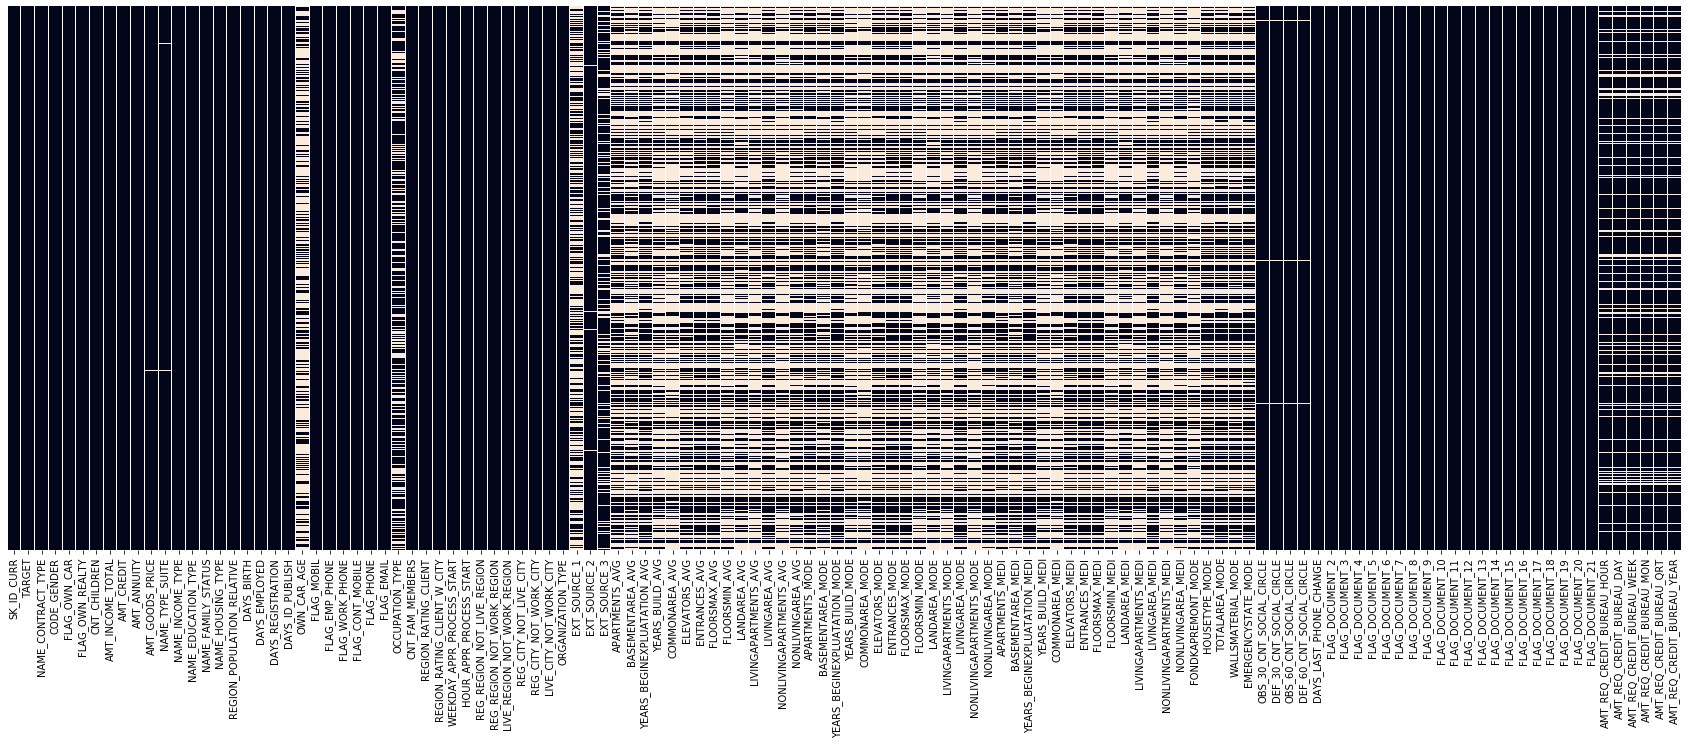

In [6]:
plt.figure(figsize=(30, 10))
sns.heatmap(train_df.isnull(), yticklabels= False , cbar = False)

As we can see, in some columns there is a high percentage of missing values. we should think of a strategy to deal with missing values.
Let's take a look to see how 

In [10]:
percentage = pd.DataFrame((train_df.isnull().sum()/train_df.shape[0]).sort_values(ascending = False))
percentage.columns = ['percentage']
percentage.head(10)

,percentage
COMMONAREA_MEDI,0.698723
COMMONAREA_AVG,0.698723
COMMONAREA_MODE,0.698723
NONLIVINGAPARTMENTS_MODE,0.694330
NONLIVINGAPARTMENTS_MEDI,0.694330
NONLIVINGAPARTMENTS_AVG,0.694330
FONDKAPREMONT_MODE,0.683862
LIVINGAPARTMENTS_MEDI,0.683550
LIVINGAPARTMENTS_MODE,0.683550
LIVINGAPARTMENTS_AVG,0.683550


## Label class distribution

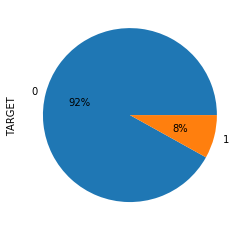

In [17]:
train_df['TARGET'].value_counts().plot(kind = 'pie' ,autopct='%1.0f%%')

As we can see the target class is unbalanced and it would be hard to train data. To solve this problem we will use undersampling technique to balance the class distribution.

## Types of columns

In [18]:
train_df.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

So we have 16 catogerical columns and we need to encode them. Let's see in detail how many categories each column have

In [27]:
for col in train_df.select_dtypes(include=['object']) :
    print('column %s has %s unique categories' % (col,len(train_df[col].unique())))

column NAME_CONTRACT_TYPE has 2 unique categories
column CODE_GENDER has 3 unique categories
column FLAG_OWN_CAR has 2 unique categories
column FLAG_OWN_REALTY has 2 unique categories
column NAME_TYPE_SUITE has 8 unique categories
column NAME_INCOME_TYPE has 8 unique categories
column NAME_EDUCATION_TYPE has 5 unique categories
column NAME_FAMILY_STATUS has 6 unique categories
column NAME_HOUSING_TYPE has 6 unique categories
column OCCUPATION_TYPE has 19 unique categories
column WEEKDAY_APPR_PROCESS_START has 7 unique categories
column ORGANIZATION_TYPE has 58 unique categories
column FONDKAPREMONT_MODE has 5 unique categories
column HOUSETYPE_MODE has 4 unique categories
column WALLSMATERIAL_MODE has 8 unique categories
column EMERGENCYSTATE_MODE has 3 unique categories


We have 16 categorical columns, in each of which from 2 to 58 different options of values. We use one-hot-encoding to transform them to numerical values.

In [9]:
# Write a function for one hot encoding to handle categorical features
def one_hot_encoding(df) :
    for col in list(df.columns) :
        if df[col].dtype == 'object' :
            df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
            df = df.drop(columns = col)  #remove the categorical column after hot encoding
    return(df)

In [105]:
train_df = one_hot_encoding(train_df)
test_df = one_hot_encoding(test_df)


In [106]:
print('size of train_df after one-hot-encoding is: ', train_df.shape)
print('size of test_df after one-hot-encoding is: ', test_df.shape)

size of train_df after one-hot-encoding is:  (307511, 246)
size of test_df after one-hot-encoding is:  (48744, 242)


As we can see we have 3 more columns(rather than target) in train dataframe compared to test dataframe. So we should make an alignment between them

In [107]:
target_label = train_df['TARGET'] #saving target column to add it afterwards since it will disappear after alignment
train_df, test_df = train_df.align(test_df, join = 'inner', axis = 1)
train_df['TARGET'] = target_label #add target column to train_df

In [108]:
print('size of train_df after alignment is: ', train_df.shape)
print('size of test_df after alignment is: ', test_df.shape)

size of train_df after alignment is:  (307511, 243)
size of test_df after alignment is:  (48744, 242)


Now the the train and test data frame are aligned

## Data correlation

In this step we calculate pearson correlation coefficient between each column and the target column, so we will have a basic understanding that which columns are more related to the target 

In [45]:
corr = train_df.corr()['TARGET'].sort_values()
print(corr.tail(15)) #to get most positively correlated features
print(corr.head(15)) #to get most negatively correlated features

DAYS_REGISTRATION                                    0.041975
OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64
EXT_SOURCE_3                           -0

As we can see Age, External soureces, gender, education, income type and region are more related to the target(although non of them has very high correlation)
Let's do some more analysis on these factors to get a better knowledge of our data

### Age

### Education level

### Gender

### Family Status

## Feature engineering 

### Adding polynomial features

In this step we try to create new features from available important ones. One way to do that is to use polynomial method and create features that are the degree of the features available. Since creating polynomial features may not always improve our model, we create another data frame with theses features and try to learn data with and without them.

We choose 5 important features(based on their correlation with target) : EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, DAYS_BIRTH, CODE_GENDER_F and use PolynomialFeatures class from Scikit-Learn with degree 3.

In [109]:
important_features = train_df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH','CODE_GENDER_F' ]]
important_features_test = test_df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH','CODE_GENDER_F' ]]
imputer = SimpleImputer(strategy = 'median') #replacing null values with the median of that column
important_features =  imputer.fit_transform(important_features)
important_features_test = imputer.fit_transform(important_features_test)
polynom = PolynomialFeatures(degree = 3)
poly_features = polynom.fit_transform(important_features) #applying PolynomialFeatures to train set
poly_features_test = polynom.fit_transform(important_features_test ) #applying PolynomialFeatures to test set
print(poly_features.shape)

(307511, 56)


Now we havve 56 polynomial features from 5 original important features. Now we calculate correlation between these polynomial features and the target to see how these features are related to the label.

In [110]:
# We create a data frame from all polynomial features that we created in previous step and then calculate correlations
poly_features = pd.DataFrame(poly_features , columns = polynom.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                    'EXT_SOURCE_3', 'DAYS_BIRTH', 'CODE_GENDER_F']))

poly_features_test = pd.DataFrame(poly_features_test , columns = polynom.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                    'EXT_SOURCE_3', 'DAYS_BIRTH', 'CODE_GENDER_F']))

poly_features.head()

,1,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,CODE_GENDER_F,EXT_SOURCE_1^2,EXT_SOURCE_1 EXT_SOURCE_2,EXT_SOURCE_1 EXT_SOURCE_3,EXT_SOURCE_1 DAYS_BIRTH,...,EXT_SOURCE_3^3,EXT_SOURCE_3^2 DAYS_BIRTH,EXT_SOURCE_3^2 CODE_GENDER_F,EXT_SOURCE_3 DAYS_BIRTH^2,EXT_SOURCE_3 DAYS_BIRTH CODE_GENDER_F,EXT_SOURCE_3 CODE_GENDER_F^2,DAYS_BIRTH^3,DAYS_BIRTH^2 CODE_GENDER_F,DAYS_BIRTH CODE_GENDER_F^2,CODE_GENDER_F^3
0,1.0,0.083037,0.262949,0.139376,-9461.0,0.0,0.006895,0.021834,0.011573,-785.612748,...,0.002707,-183.785678,0.000000,1.247560e+07,-0.000000,0.000000,-8.468590e+11,0.0,-0.0,0.0
1,1.0,0.311267,0.622246,0.535276,-16765.0,1.0,0.096887,0.193685,0.166614,-5218.396475,...,0.153368,-4803.518937,0.286521,1.504475e+08,-8973.906339,0.535276,-4.712058e+12,281065225.0,-16765.0,1.0
2,1.0,0.505998,0.555912,0.729567,-19046.0,0.0,0.256034,0.281290,0.369159,-9637.236584,...,0.388325,-10137.567875,0.000000,2.646504e+08,-0.000000,0.000000,-6.908939e+12,0.0,-0.0,0.0
3,1.0,0.505998,0.650442,0.535276,-19005.0,1.0,0.256034,0.329122,0.270849,-9616.490669,...,0.153368,-5445.325225,0.286521,1.933364e+08,-10172.925140,0.535276,-6.864416e+12,361190025.0,-19005.0,1.0
4,1.0,0.505998,0.322738,0.535276,-19932.0,0.0,0.256034,0.163305,0.270849,-10085.550751,...,0.153368,-5710.929881,0.000000,2.126570e+08,-0.000000,0.000000,-7.918677e+12,0.0,-0.0,0.0


In [111]:
poly_features = poly_features.drop('1' , axis = 1) # The first featur with degree 0 is useless so we drop it
poly_features_test = poly_features_test.drop('1' , axis = 1)
poly_features ['TARGET'] = train_df['TARGET']
corr = poly_features.corr()['TARGET'].sort_values()
print(corr.tail(15)) #to get most positively correlated features
print(corr.head(15)) #to get most negatively correlated features

DAYS_BIRTH CODE_GENDER_F^2               0.075350
DAYS_BIRTH                               0.078239
EXT_SOURCE_1 DAYS_BIRTH CODE_GENDER_F    0.091402
EXT_SOURCE_1^2 DAYS_BIRTH                0.097507
EXT_SOURCE_1 DAYS_BIRTH                  0.104882
EXT_SOURCE_2 DAYS_BIRTH CODE_GENDER_F    0.113053
EXT_SOURCE_3 DAYS_BIRTH CODE_GENDER_F    0.114184
EXT_SOURCE_3^2 DAYS_BIRTH                0.141777
EXT_SOURCE_2^2 DAYS_BIRTH                0.149313
EXT_SOURCE_3 DAYS_BIRTH                  0.150109
EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH     0.151816
EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH     0.155891
EXT_SOURCE_2 DAYS_BIRTH                  0.156873
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     0.181283
TARGET                                   1.000000
Name: TARGET, dtype: float64
EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_

In [112]:
poly_features.shape

(307511, 56)

As we can see now, some of these polynomial features have more correlation with the target class.

Now we create new train and test data sets and add these polynomial features. Later for training model we also use these datasets with polynomial features to see if it would improve our model.

In [117]:
poly_features['SK_ID_CURR'] = train_df['SK_ID_CURR']  #adding Id column so we can merge these datasets later
poly_features = poly_features.drop('TARGET', axis = 1)
poly_features_test['SK_ID_CURR'] = test_df['SK_ID_CURR']
poly_train = train_df.merge(poly_features, on = 'SK_ID_CURR', how = 'left')
poly_test = test_df.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')
poly_train.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH_x,DAYS_EMPLOYED,DAYS_REGISTRATION,...,EXT_SOURCE_3^3,EXT_SOURCE_3^2 DAYS_BIRTH,EXT_SOURCE_3^2 CODE_GENDER_F,EXT_SOURCE_3 DAYS_BIRTH^2,EXT_SOURCE_3 DAYS_BIRTH CODE_GENDER_F,EXT_SOURCE_3 CODE_GENDER_F^2,DAYS_BIRTH^3,DAYS_BIRTH^2 CODE_GENDER_F,DAYS_BIRTH CODE_GENDER_F^2,CODE_GENDER_F^3
0,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,...,0.002707,-183.785678,0.000000,1.247560e+07,-0.000000,0.000000,-8.468590e+11,0.0,-0.0,0.0
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,...,0.153368,-4803.518937,0.286521,1.504475e+08,-8973.906339,0.535276,-4.712058e+12,281065225.0,-16765.0,1.0
2,100004,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,...,0.388325,-10137.567875,0.000000,2.646504e+08,-0.000000,0.000000,-6.908939e+12,0.0,-0.0,0.0
3,100006,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,...,0.153368,-5445.325225,0.286521,1.933364e+08,-10172.925140,0.535276,-6.864416e+12,361190025.0,-19005.0,1.0
4,100007,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,...,0.153368,-5710.929881,0.000000,2.126570e+08,-0.000000,0.000000,-7.918677e+12,0.0,-0.0,0.0


## Adding data from other tables

### <font color='blue'>bureau_balance table</font>


In [6]:
bureau_balance = pd.read_csv("bureau_balance.csv")
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [122]:
bureau_balance["STATUS"].unique()

array(['C', '0', 'X', '1', '2', '3', '5', '4'], dtype=object)

Meaning of differnet values of STATUS clumn is as following :


C - closed, that is, repaid credit. X - unknown status. 0 - current loan, no delinquency. 1 - 1-30 days overdue, 2 - 31-60 days overdue, and so on up to status 5 - the loan is sold to a third party or written off

We can use this STATUS column and define a risk factor by allocating a value to each status and then calculate sum of them for each SK_ID_BUREAU

In [7]:
bureau_balance['STATUS'] = bureau_balance['STATUS'].map({'C' : 0 , '0' : 0 , 'X' : .1 , '1' : 1 , 
                                                      '2' : 2 , '3' : 3 , '4' :4 , '5' : 5})
# Allocate .1 for X because in this case the status is unknown and it's not reasonable to map a high risk to it

bureau_balance_final = bureau_balance.groupby('SK_ID_BUREAU', as_index=False)['STATUS'].sum()
bureau_balance_final = bureau_balance_final.rename(columns = {'STATUS' : 'BB_RISK'})
bureau_balance_final.head()


,SK_ID_BUREAU,BB_RISK
0,5001709,1.1
1,5001710,3.0
2,5001711,0.1
3,5001712,0.0
4,5001713,2.2


### <font color='blue'>bureau table</font> 

In this step, we first add the risk value that we calculated in previous step to the bureau table and fill null values with 0 

In [10]:
bureau = pd.read_csv("bureau.csv")
bureau= bureau.merge(bureau_balance_final, on = 'SK_ID_BUREAU', how = 'left')
bureau['BB_RISK'] = bureau['BB_RISK'].fillna(0) 
bureau = one_hot_encoding(bureau)
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,...,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
0,215354,5714462,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,215354,5714463,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,...,0,0,0,0,0,0,0,0,0,0
2,215354,5714464,-203,0,528.0,NaN,NaN,0,464323.5,NaN,...,0,0,0,0,0,0,0,0,0,0
3,215354,5714465,-203,0,NaN,NaN,NaN,0,90000.0,NaN,...,0,0,0,0,0,0,0,0,0,0
4,215354,5714466,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,...,0,0,0,0,0,0,0,0,0,0


Now we get the mean of bureau table features for each SK_ID_CURR and also number of previous loans that each customer got before

In [13]:
bureau_mean = bureau.groupby('SK_ID_CURR').mean()
previous_loans = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count() #number of previous loans for each customer
previous_loans = previous_loans.rename(columns = {"SK_ID_CURR" : "SK_ID_CURR", "SK_ID_BUREAU" : "PLoan_num"})
bureau_mean= bureau_mean.merge(previous_loans, on = 'SK_ID_CURR', how = 'left')
bureau_mean = bureau_mean.drop(columns = "SK_ID_BUREAU" )
bureau_mean.head()


,SK_ID_CURR,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,PLoan_num
0,100001,-735.000000,0.0,82.428571,-825.500000,NaN,0.0,207623.571429,85240.928571,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
1,100002,-874.000000,0.0,-349.000000,-697.500000,1681.029,0.0,108131.945625,49156.200000,7997.14125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
2,100003,-1400.750000,0.0,-544.500000,-1097.333333,0.000,0.0,254350.125000,0.000000,202500.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,100004,-867.000000,0.0,-488.500000,-532.500000,0.000,0.0,94518.900000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,100005,-190.666667,0.0,439.333333,-123.000000,0.000,0.0,219042.000000,189469.500000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


Now we define a new variable from exisiting varaibles that may be useful and it is how often the cusomer took loans in past, was it on a regular basis or for a short period? Each can have different interpretation.


In [14]:
frequency = bureau[['SK_ID_CURR', 'SK_ID_BUREAU', 'DAYS_CREDIT']].groupby(by=['SK_ID_CURR'])
frequency1 =  frequency.apply(lambda x: x.sort_values(['DAYS_CREDIT'], ascending=False)).reset_index(drop=True)
frequency1['Loan_FRQ'] = frequency1.groupby(by=['SK_ID_CURR'])['DAYS_CREDIT'].diff()

Now need to find mean of Loan_FRQ for each SK_ID_CURR. First, I drop null values(beacause when we calculate diff, the diff value for the first bureau of each SK_ID_CURR is NAN ) and then calculate mean values for each SK_ID_CURR

In [17]:
frequency1 = frequency1.dropna(subset = ['Loan_FRQ'])
frequency1 = frequency1.groupby('SK_ID_CURR', as_index=False)['Loan_FRQ'].mean()




# Now we should merge frequency1 and bureau_mean database
bureau_mean= bureau_mean.merge(frequency1, on = 'SK_ID_CURR', how = 'left')

#we have null values in Loan_FRQ column if there was just 1 previous loan
#fill null values of this column with the value  of DAYS_CREDIT column
bureau_mean["Loan_FRQ"] = np.where(bureau_mean["Loan_FRQ"].isnull(), bureau_mean['DAYS_CREDIT'], bureau_mean["Loan_FRQ"])

bureau_mean["Loan_FRQ"] = bureau_mean["Loan_FRQ"].abs()


bureau_mean.head(10)

,SK_ID_CURR,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,...,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,PLoan_num,Loan_FRQ_x,Loan_FRQ_y,Loan_FRQ
0,100001,-735.000000,0.0,82.428571,-825.500000,NaN,0.0,207623.571429,85240.928571,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,7,253.833333,-253.833333,253.833333
1,100002,-874.000000,0.0,-349.000000,-697.500000,1681.029,0.0,108131.945625,49156.200000,7997.14125,...,0.0,0.0,0.0,0.0,0.0,0.0,8,190.571429,-190.571429,190.571429
2,100003,-1400.750000,0.0,-544.500000,-1097.333333,0.000,0.0,254350.125000,0.000000,202500.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,4,660.000000,-660.000000,660.000000
3,100004,-867.000000,0.0,-488.500000,-532.500000,0.000,0.0,94518.900000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,2,918.000000,-918.000000,918.000000
4,100005,-190.666667,0.0,439.333333,-123.000000,0.000,0.0,219042.000000,189469.500000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,3,155.500000,-155.500000,155.500000
5,100007,-1149.000000,0.0,-783.000000,-783.000000,0.000,0.0,146250.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1149.000000,NaN,1149.000000
6,100008,-757.333333,0.0,-391.333333,-909.000000,0.000,0.0,156148.500000,80019.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,3,509.500000,-509.500000,509.500000
7,100009,-1271.500000,0.0,-794.937500,-1108.500000,0.000,0.0,266711.750000,76953.535714,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,18,155.470588,-155.470588,155.470588
8,100010,-1939.500000,0.0,-119.500000,-1138.000000,NaN,0.0,495000.000000,174003.750000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,2,1603.000000,-1603.000000,1603.000000
9,100011,-1773.000000,0.0,-1293.250000,-1463.250000,5073.615,0.0,108807.075000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,4,399.666667,-399.666667,399.666667


In [18]:
# Now we fill null values with the value of median
imputer = SimpleImputer(strategy = "median")
imputer.fit(bureau_mean)
bureau_mean.loc[:] = imputer.transform(bureau_mean)



# Note : at the end when we processed all tables, we merge them with the train and test set and fill the null values 
# in new columns with 0 

### <font color='blue'>POS_CASH_balance table</font>

### <font color='blue'>installments_payments table</font> 

### <font color='blue'>credit_card_balance table</font> 

### <font color='blue'>previous_application table</font> 